In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
X_train = pd.read_csv('data/input/non_standardized_X_train.csv', index_col=0)
y_train = pd.read_csv('data/input/y_train.csv', index_col=0)

In [3]:
X_test = pd.read_csv('data/input/non_standardized_X_test.csv', index_col=0)

In [4]:
np.random.seed(42)

### 10-fold Cross-Validation

In [5]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [6]:
def kfold_mse(X, y, model, k=10):
    kf = KFold(n_splits=k)
    mses = []
    for i, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        model.fit(X_train, y_train['sales']) # Avoid deprecation warning
        y_pred = model.predict(X_val)
        mses.append(mean_squared_error(y_pred, y_val['sales']))
    return mses

Gradient boosting have even more tunable parameters than random forest, therefore we shall concern only `learning_rate` and `max_depth` in this project. `n_estimators`, `max_features`, `min_samples_split` are fixed to 1000, 'sqrt' and 0.01. Since boosting is robust to overfitting, we can use as many estimators as computationally feasible.

In [7]:
learning_rates = [0.01, 0.1, 0.5, 1]
max_depths = [None, 3, 5, 10]

In [8]:
from sklearn.ensemble import GradientBoostingRegressor

In [9]:
best_mses = []
best_avg_score = 1e9
best_lr = None
best_depth = None
for lr in learning_rates:
    for depth in max_depths:
        model = GradientBoostingRegressor(min_samples_split=0.01, n_estimators=1000, max_features='sqrt', random_state=42, learning_rate=lr, max_depth=depth)
        mses = kfold_mse(X_train, y_train, model)
        if np.mean(mses) < best_avg_score:
            best_avg_score = np.mean(mses)
            best_lr = lr
            best_depth = depth
            best_mses = mses
        print(f'lr: {lr}, max_depth: {depth}, avg_mse: {np.mean(mses)}')

lr: 0.01, max_depth: None, avg_mse: 275.2030500192398
lr: 0.01, max_depth: 3, avg_mse: 345.195856634741
lr: 0.01, max_depth: 5, avg_mse: 288.7965775409493
lr: 0.01, max_depth: 10, avg_mse: 264.45701800501683
lr: 0.1, max_depth: None, avg_mse: 277.82236500119745
lr: 0.1, max_depth: 3, avg_mse: 275.3584554132232
lr: 0.1, max_depth: 5, avg_mse: 264.1075348012218
lr: 0.1, max_depth: 10, avg_mse: 259.6133497295818
lr: 0.5, max_depth: None, avg_mse: 430.7672215187632
lr: 0.5, max_depth: 3, avg_mse: 348.787383909608
lr: 0.5, max_depth: 5, avg_mse: 345.16471822077267
lr: 0.5, max_depth: 10, avg_mse: 397.25677461714605
lr: 1, max_depth: None, avg_mse: 659.7936960491577
lr: 1, max_depth: 3, avg_mse: 493.3456473592449
lr: 1, max_depth: 5, avg_mse: 532.8961318774893
lr: 1, max_depth: 10, avg_mse: 683.4485154579224


### In-sample analysis

In [10]:
cv_df = pd.DataFrame(best_mses, columns=['Cross-Validation MSE'])
cv_df

,Cross-Validation MSE
0,172.144269
1,111.496293
2,311.989428
3,210.067128
4,190.167632
5,119.701759
6,375.382911
7,208.147390
8,741.356620
9,155.680068


In [11]:
cv_df.to_csv('data/output/cv/gbr.csv')

### Model fitting

After finding best parameters (not applicable to LR but useful for other models), we fit the model on the entire training set and predict on the test set. Also, we collect residuals to prepare for inventory decision making.

In [12]:
gbr = GradientBoostingRegressor(min_samples_split=0.01, n_estimators=1000, max_features='sqrt', random_state=42, learning_rate=best_lr, max_depth=best_depth)
gbr.fit(X_train, y_train['sales']) # Avoid deprecation warning
residuals = y_train['sales'] - gbr.predict(X_train)

In [13]:
output_df = X_test.copy()

In [14]:
output_df['sales'] = gbr.predict(X_test)

### Inventory decision
As sales data come from a natural process, we shall not assume it is distributed in any particular model. Hence, we shall use an empirical distribution to make our inventory decision. 

In [15]:
residuals.describe()

count    2.211000e+03
mean     2.933479e-16
std      1.498750e-02
min     -7.472476e-02
25%     -7.891818e-03
50%     -1.015931e-04
75%      8.337780e-03
max      9.183763e-02
Name: sales, dtype: float64

For visualization of Empirical CDF, we use the `statsmodels` package:

In [16]:
from statsmodels.distributions.empirical_distribution import ECDF

In [17]:
ecdf = ECDF(residuals)

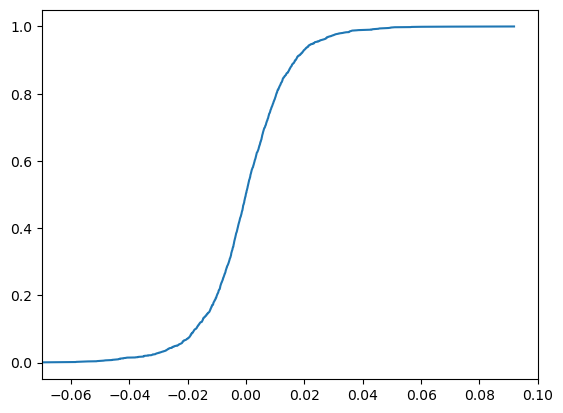

In [26]:
plt.plot(ecdf.x, ecdf.y)
plt.xlim(-0.07, 0.1)
plt.show()

Sparsity is not a concern since we have a large sample size. Therefore, we can use interpolation to obtain ppf. To get the empirical ppf, we can use scipy's `interp1d` to get the inverse function:

In [19]:
from scipy.interpolate import interp1d

In [20]:
eppf = interp1d(ecdf.y, ecdf.x)

Calculate the critical fractile

In [21]:
price = 20
cost = 12
salvage = 8
over = cost - salvage
under = price - cost
critical_fractile = under / (over + under)
critical_fractile

0.6666666666666666

We offset our predictions for the test datasets by the $eppf(critical\_fractile)$ to get the optimal inventory level.

In [22]:
output_df['inventory'] = eppf(critical_fractile) + output_df['sales']

In [23]:
output_df[['sales', 'inventory']].head()

,sales,inventory
0,33.624707,33.630013
1,77.898034,77.903340
2,9.025293,9.030598
3,19.737750,19.743056
4,9.617186,9.622492


In [24]:
output_df.to_csv('data/output/predictions/gbr.csv')